In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import os
import imageio
import seaborn as sns
import warnings
import sympy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,6)},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")
warnings.filterwarnings("default")

/Users/cygnari/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [16]:
llns = np.loadtxt(f'LLNsnew.dat', unpack=True)[1:4,] # column 0 is h', column 1 is l', column 2 is k'

In [17]:
h1 = llns[1, 0]
l1 = llns[1, 1]
k1 = llns[1, 2]

llns[1, 0] = 2 / 3 * (h1 - l1)
llns[1, 1] = -1 / 3 * (h1 - l1)
llns[1, 2] = -1 / 3 * h1 - 2 / 3 * l1 - 1

In [18]:
rho = 1035 # density of seawater is on average 1035 kg/m^3
rhoe = 5517 # density of earth is on average 5517 kg/m^3
earthradius = 6371000 # radius of earth in meters

In [19]:
def alpha(n):
    return 3 * rho * (1 + llns[2, n] - llns[0, n]) / (rhoe * (2 * n + 1))

In [20]:
def gfsphcoeff(n):
    return alpha(n) / (2 * math.pi) * np.sqrt((2 * n + 1) / (4 * math.pi))

In [37]:
def Nvalue(n, m, const, lats, dlat): # const = -1 for sine, +1 for cosine 
    
    vals = 1 / 2 * np.cos(lats) * np.square(sp.special.lpmv(m, n, np.sin(lats))) * (math.pi + const * np.sin(m * math.pi) / m)
    out = np.sum(vals * dlat) # multiply by dlon inside to help prevent overlow
#     if np.abs(out) > 1e-50:
#         return out
#     else:
#         return np.inf
    return out

In [51]:
def updatefunc(n, m, phid, thetad, phi, theta):
#     print(phid, thetad, phi, theta)
    dlat = phid[1] - phid[0]
    part1 = np.cos(m * theta) * np.cos(m * thetad) / Nvalue(n, m, 1, phid, dlat)
    part2 = np.sin(m * theta) * np.sin(m * thetad) / Nvalue(n, m, -1, phid, dlat)
    part3 = np.nan_to_num(sp.special.lpmv(m, n, np.sin(phi - math.pi / 2)) * sp.special.lpmv(m, n, np.sin(phid - math.pi / 2)), nan=0.0, posinf=0.0, neginf=0.0)
    # print(part1, part2, part3)
    return (part1 + part2) * part3

In [52]:
def innersum(phid, thetad, phi, theta, n):
    runningsum = np.zeros(np.shape(phid))
    for m in range(-n, 0):
        runningsum = runningsum + np.nan_to_num(updatefunc(n, m, phid, thetad, phi, theta), copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        runningsum = runningsum + np.nan_to_num(updatefunc(n, -m, phid, thetad, phi, theta), copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        runningsum = np.nan_to_num(runningsum, copy=False, nan=0.0, posinf=0.0, neginf=0.0) # fix numerical instability issues in legendre polynomial evaluation
        # print(m, runningsum)
#     runningsum = runningsum + updatefunc(n, 0, phid, thetad, phi, theta)
    return runningsum

In [41]:
def greenfunc(phid, thetad, phi, theta, stop):
    out = np.zeros((stop,) + np.shape(phid))
    for n in range(stop): 
        newpart = gfsphcoeff(n) * sp.special.sph_harm(0, n, theta - thetad, phi - phid) + innersum(phid, thetad, phi, theta, n)
        out[n] = np.real(newpart)
    
    return out

In [42]:
def greenfuncsum(phid, thetad, phi, theta, stop):
    vals = greenfunc(phid, thetad, phi, theta, stop)
    return np.sum(vals, axis=0)

In [84]:
latvals = np.deg2rad(np.mgrid[0:180:1])
response = greenfuncsum(latvals, 0, 0, 0, 200) 
polyfit = np.polynomial.polynomial.Polynomial.fit(latvals, response, 30, domain=[0, math.pi])

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/3049461710.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  part1 = np.cos(m * theta) * np.cos(m * thetad) / Nvalue(n, m, 1, phid, dlat)
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/3049461710.py:5: RuntimeWarning: invalid value encountered in double_scalars
  part2 = np.sin(m * theta) * np.sin(m * thetad) / Nvalue(n, m, -1, phid, dlat)
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/3049461710.py:8: RuntimeWarning: invalid value encountered in multiply
  return (part1 + part2) * part3
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/3049461710.py:4: RuntimeWarning: overflow encountered in double_scalars
  part1 = np.cos(m * theta) * np.cos(m * thetad) / Nvalue(n, m, 1, phid, dlat)
/Users/cygnari/.pyenv/versions/3.10.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

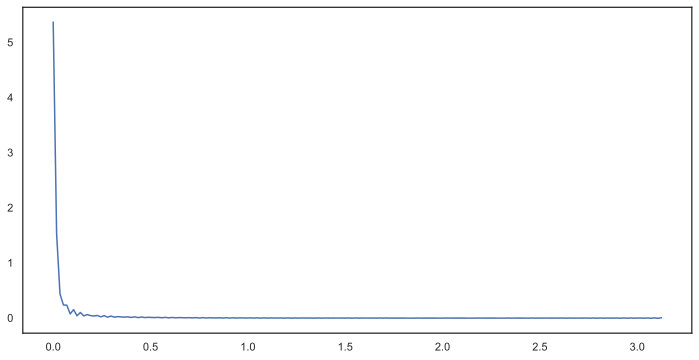

In [85]:
plt.plot(latvals, response)
plt.show()

In [43]:
def gcdists(lons, lats, pointlon, pointlat): # great circle distance to (pointlon, pointlat) on earth
    lats = math.pi / 2 - lats
    pointlat = math.pi / 2 - pointlat
    return np.arccos(np.maximum(np.minimum(np.sin(pointlat) * np.sin(lats) + np.cos(pointlat) * np.cos(lats) * np.cos((lons - pointlon)), 1), -1))

In [44]:
def salpotential(lons, lats, areas, ssh, greenfunc, lonvals, latvals):
    salpot = np.zeros(np.shape(areas))
    for i in range(len(lonvals)):
        for j in range(len(latvals)):
            distances = gcdists(lons, lats, lonvals[i], latvals[j])
            salpot[i, j] = np.sum(greenfunc(distances) * ssh * areas)
    
    return salpot

In [86]:
def amplitudeerrors(dlat, dlon):
    latvals = np.deg2rad(np.mgrid[0:180:dlat])
    lonvals = np.deg2rad(np.mgrid[0:360:dlon])
    lats, lons = np.meshgrid(latvals, lonvals)
    areas = np.zeros(np.shape(lons))
    
    for i in range(len(latvals)):
        for j in range(len(lonvals)):
            areas[j, i] = np.sin(latvals[i]) * (latvals[1] - latvals[0]) * (lonvals[1] - lonvals[0])
#             areas[j, i] = np.sin(latvals[i])
            
#     response = greenfuncsum(latvals, 0, 0, 0, 10) 
#     polyfit = np.polynomial.polynomial.Polynomial.fit(latvals, response, 30, domain=[0, math.pi])
    ssh = np.real(sp.special.sph_harm(2, 3, lons, lats))
    test = salpotential(lons, lats, areas, ssh, polyfit, lonvals, latvals) 
    realresponse = alpha(3) * ssh
    return (test / realresponse)[0,:], latvals
#     return lats, lons, test

In [92]:
error1, lats1 = amplitudeerrors(1, 1)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [ ]:
error2, lats2 = amplitudeerrors(0.5, 0.5)

In [89]:
error3, lats3 = amplitudeerrors(2, 2)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: invalid value encountered in divide
  return (test / realresponse)[0,:], latvals


In [90]:
error4, lats4 = amplitudeerrors(3, 3)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


In [88]:
error5, lats5 = amplitudeerrors(6, 6)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_23146/4098073522.py:17: RuntimeWarning: divide by zero encountered in divide
  return (test / realresponse)[0,:], latvals


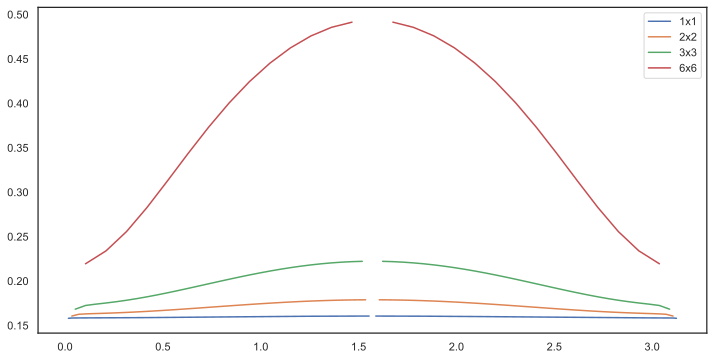

In [93]:
# plt.plot(lats2, error2, label='0.5x0.5')
plt.plot(lats1, error1, label='1x1')
plt.plot(lats3, error3, label='2x2')
plt.plot(lats4, error4, label='3x3')
plt.plot(lats5, error5, label='6x6')
plt.legend()
# plt.yscale('log')
plt.show()

In [24]:
error1[89]

0.34668301463237705